## Customized CNNs for Weed Groth Estimation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Description ,Visualization and Splitting

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a>

For this work a subset of Teimouri's contains 1000 images is utilized and splitted as follows:

*  800 training
*  100 testing
*  100 validation



In [ ]:
import tensorflow as tf
import math
from sklearn.metrics import accuracy_score
import keras
import pathlib
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Data Visualization

/content/drive/MyDrive/Colab Notebooks/CV_Assignment_3/training
5
25


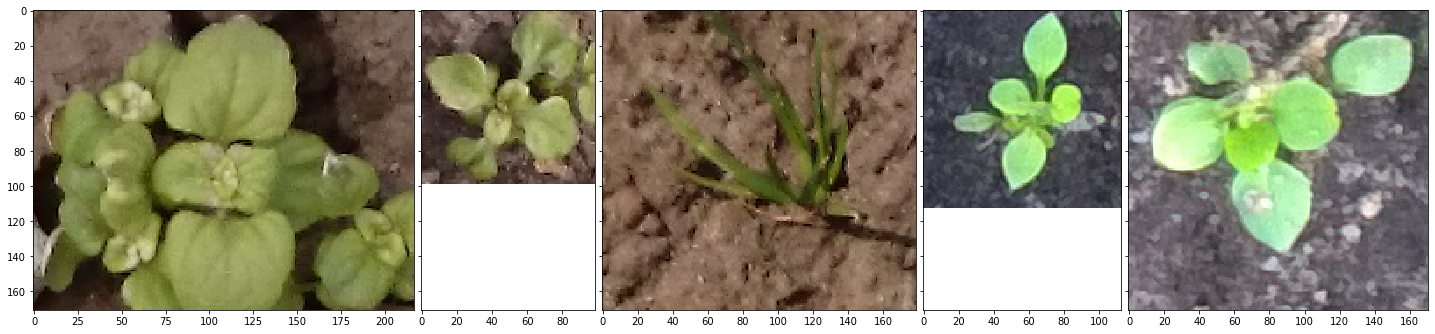

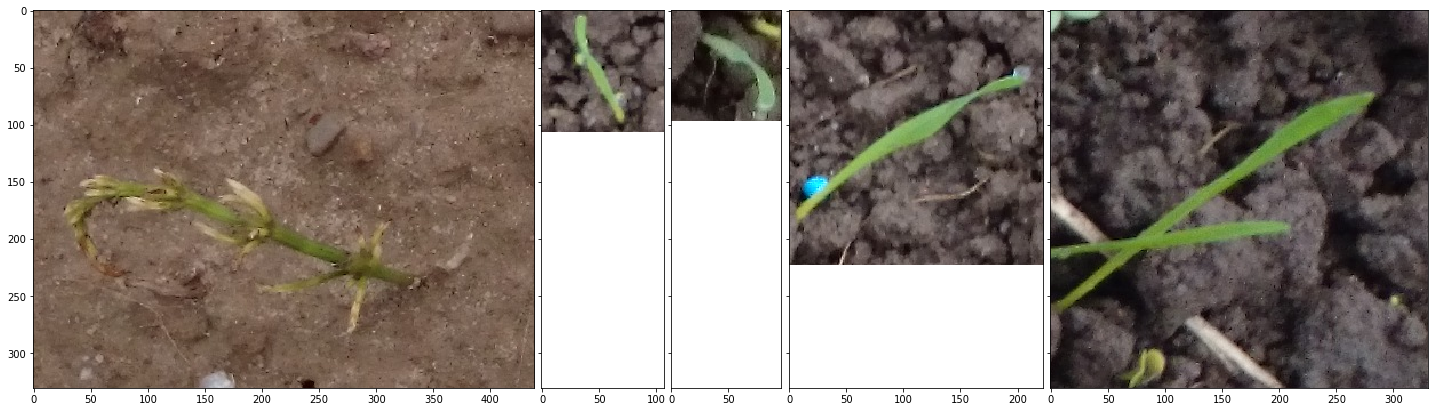

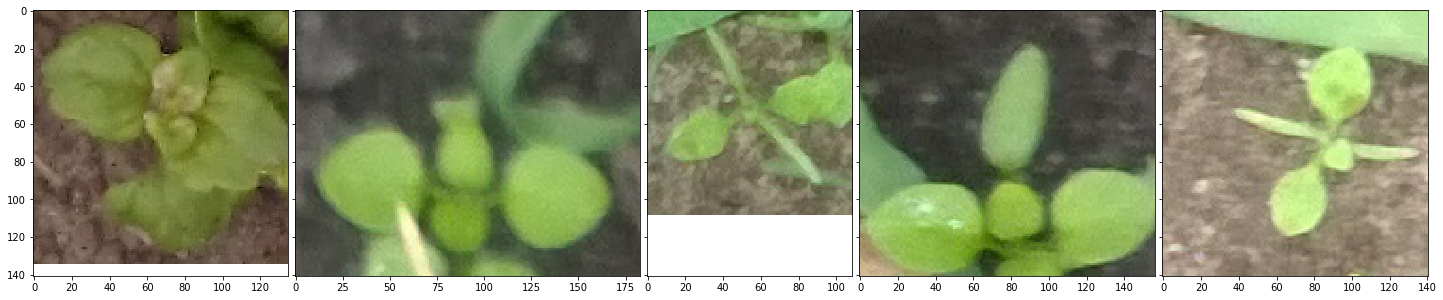

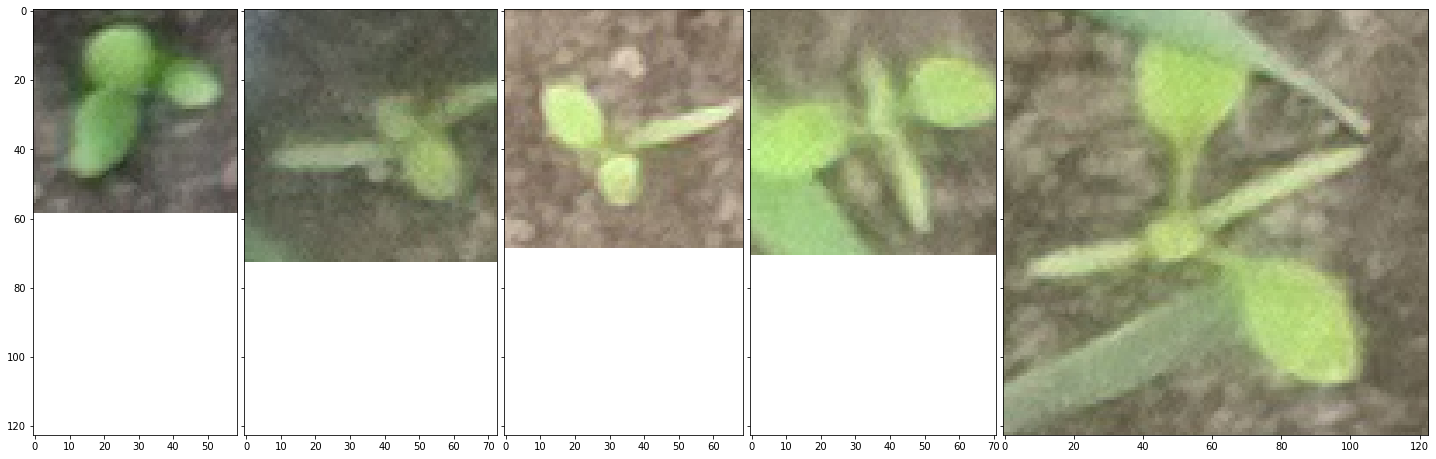

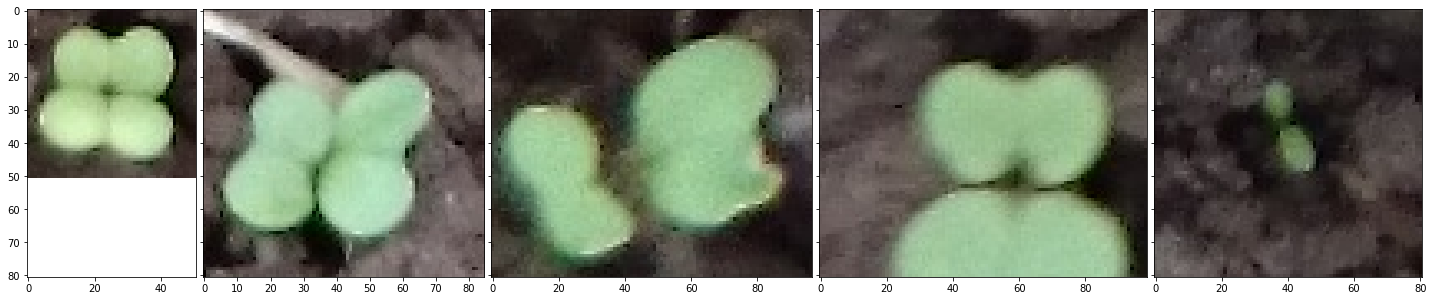

In [ ]:
# Prepare your dataset here

train_directory='/content/drive/MyDrive/Colab Notebooks/CV_Assignment_3/training'
test_directory='/content/drive/MyDrive/Colab Notebooks/CV_Assignment_3/testing'

data_dir = pathlib.Path(train_directory)
print(data_dir)
images_list=list(data_dir.glob('*/*.png'))

classes_list=list(data_dir.glob('*'))

print(len(classes_list))

list_imgs=[]

for label in classes_list:
    class_list=list(label.glob('*.png'))
    for j in range(5):
        list_imgs.append(class_list[j])
     
      

print(len(list_imgs))     
for i in range(5):       
    limgs=list_imgs[i*5:(i+1)*5]
    fig = plt.figure(figsize=(25., 14.))
 
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(1, 5),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, limgs):
        im=plt.imread(im)
        ax.imshow(im, interpolation='none', cmap=plt.cm.gray)
    plt.title(f"visualizing the patch {i} in dataset")
    plt.show()

## Visualization Note


*   It seems that it's a very hard to distinguash between the plants with 3 leafs and the plants with 4 leafs, which wouldmake it a tough problem for the model.
*   Plants with on e leaf is the most distinguashed
*   Other plants have similar specifications.








## Data Importing for Regression and classification and Splitting

In [ ]:
#Data Importing and Preparation

epochs_num=100
patience=25
batch_size=32
target_size=(128, 128)
train_directory='/content/drive/MyDrive/Colab Notebooks/CV_Assignment_3/training'
test_directory='/content/drive/MyDrive/Colab Notebooks/CV_Assignment_3/testing'

#Data Importing For Classification with SoftMax 
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=1/9)
#Train Data Shuffle = True for training
train_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=target_size,
        batch_size=batch_size, class_mode="categorical",subset='training',
        seed = 24,
    )
#Data Shuffle = False for Testing
train_generator_to_test_with = train_datagen.flow_from_directory(
        train_directory,
        target_size=target_size,shuffle=False,
        batch_size=batch_size, class_mode="categorical",subset='training',
        seed = 24,
    )
valid_generator = train_datagen.flow_from_directory(
        train_directory,
        target_size=target_size,shuffle=False,
        batch_size=batch_size, class_mode="categorical",subset='validation',
        seed = 24,
    )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=target_size,shuffle=False,
        batch_size=batch_size,
        seed = 24,class_mode="categorical"
    )

#Data Importing for Regressin with Relu
train_datagen_rg = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=1/9)
#Train Data Shuffle = True for training
train_generator_rg = train_datagen_rg.flow_from_directory(
        train_directory,
        target_size=target_size,
        seed = 24,batch_size=batch_size, class_mode="sparse",subset='training'
    )
#Data Shuffle = False for Testing
train_generator_rg_to_test_with = train_datagen_rg.flow_from_directory(
        train_directory,
        target_size=target_size,shuffle=False,
        seed = 24,batch_size=batch_size, class_mode="sparse",subset='training'
    )
valid_generator_rg = train_datagen_rg.flow_from_directory(
        train_directory,
        target_size=target_size,shuffle=False,
        seed = 24,batch_size=batch_size, class_mode="sparse",subset='validation'
    )
test_datagen_rg = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator_rg = test_datagen_rg.flow_from_directory(
        test_directory,
        target_size=target_size,shuffle=False,
        seed = 24,batch_size=batch_size,
        class_mode="sparse"
    )



model_to_take_layers_from=tf.keras.applications.VGG16(include_top=False,
    weights="imagenet",
    classes=5,
    
)

Found 800 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Found 800 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
58889256/58889256 [==============================] - 0s 0us/step


### Auxiliary Function

In [ ]:

#Function to train and evalate the model ,plot loss, accuracy confusion matrices
def compile_fit_plot(train_ds,traintest_ds,valid_ds,test_ds,model,opt,epochs_num,size_batch,model_name,loss,mode):
    #Early Stopping Based on the validation loss to work well with regression
    cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = patience)
    model.compile( loss = loss, optimizer = opt, metrics=['accuracy'])

    # Train the model
    history = model.fit( train_ds, epochs=epochs_num, batch_size=size_batch,
        validation_data =valid_ds, callbacks=[cb_early_stopper], verbose=0 )
    model.summary()

    f=plt.subplot(2,1,1)
    f.figure.set_size_inches(30,10)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['train acc', 'test acc when treated as val']) 
    plt.title(f"Accuracies For {model_name}")
    plt.xlabel("# of epochs")
    plt.ylabel("accuracy")
    
    plt.grid()
    f=plt.subplot(2,1,2)
    f.figure.set_size_inches(30,10)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train loss', 'test loss when treated as val'])
    plt.xlabel("# of epochs")
    plt.title(f"losses For {model_name}")
    
    plt.grid()
    plt.show()
    
    f, axes = plt.subplots(1, 3, figsize=(24, 8), sharey='row')
    
    print('Training Evaluation',model.evaluate(traintest_ds))
    train_predictions = model.predict(traintest_ds)
    if mode=='class':
        
        train_pred=np.argmax(train_predictions, axis = 1)
        print('Accuracy Score Training after Predict',accuracy_score(traintest_ds.classes, train_pred))
    elif mode=='reg':
        train_pred = np.array([round(float(num)) for num in train_predictions])
        print('Accuracy Score Training after Predict',accuracy_score(traintest_ds.classes, train_pred))
        
    cf_matrix = confusion_matrix(traintest_ds.classes, train_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[0], xticks_rotation=0)
    disp.ax_.set_title('Confusion Matrix For Training' )
    disp.im_.colorbar.remove()
    
    
    
    print('Validation Evaluation',model.evaluate(valid_ds))
    v_predictions = model.predict(valid_ds)
    if mode=='class':
        
        v_pred=np.argmax(v_predictions, axis = 1)
        print('Accuracy Score Validation after Predict',accuracy_score(valid_ds.classes, v_pred))
    elif mode=='reg':
        v_pred = np.array([round(float(num)) for num in v_predictions])
        print('Accuracy Score Validation after Predict',accuracy_score(valid_ds.classes, v_pred))
        
    cf_matrix = confusion_matrix(valid_ds.classes, v_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[1], xticks_rotation=0)
    disp.ax_.set_title('Confusion Matrix For Validation' )
    disp.im_.colorbar.remove()
    
    print('Testing Evaluation',model.evaluate(test_ds))
    
    test_predictions = model.predict(test_ds)
    if mode=='class':
        test_pred=np.argmax(test_predictions, axis = 1)
        print('Accuracy Score Testing after Predict',accuracy_score(test_ds.classes, test_pred))
    elif mode=='reg':
        test_pred = np.array([round(float(num)) for num in test_predictions])
        print('Accuracy Score Testing after Predict',accuracy_score(test_ds.classes, test_pred))
        
    cf_matrix = confusion_matrix(test_ds.classes, test_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[2], xticks_rotation=0)
    disp.ax_.set_title('Confusion Matrix For Testing' )
    disp.im_.colorbar.remove()
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()
    return model

## Transfer Learning - Classification Network

The first 2 blocks of the Keras implementation of VGG-16 were used in the following cell as a base blockss to build a customized CNN Classification Network to classify the images according to the number of leaves in the plant images. 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   1

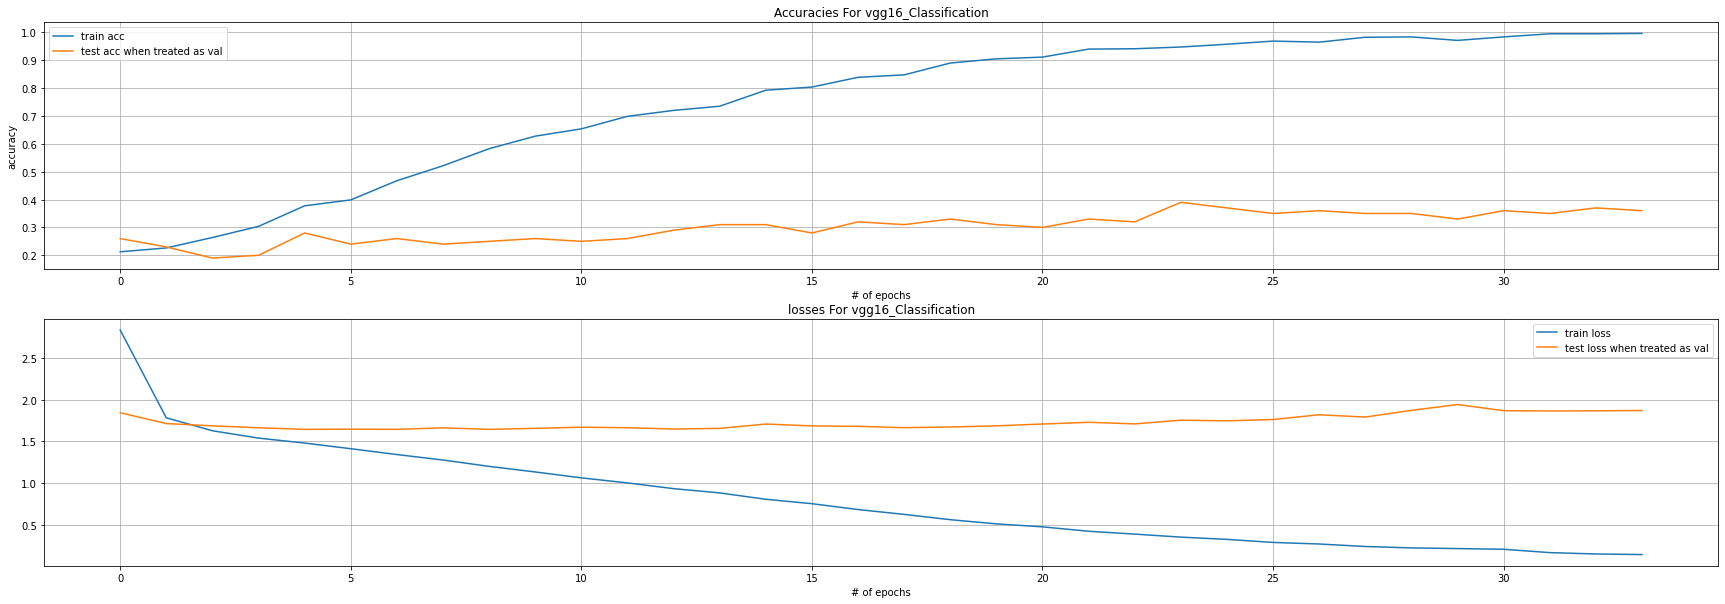

25/25 [==============================] - 3s 134ms/step - loss: 0.1190 - accuracy: 1.0000
Training Evaluation [0.11897147446870804, 1.0]
25/25 [==============================] - 3s 136ms/step
Accuracy Score Training after Predict 1.0
4/4 [==============================] - 0s 105ms/step - loss: 1.8689 - accuracy: 0.3600
Validation Evaluation [1.8688632249832153, 0.36000001430511475]
4/4 [==============================] - 0s 108ms/step
Accuracy Score Validation after Predict 0.36
4/4 [==============================] - 68s 23s/step - loss: 2.3533 - accuracy: 0.3100
Testing Evaluation [2.353261709213257, 0.3100000023841858]
4/4 [==============================] - 1s 150ms/step
Accuracy Score Testing after Predict 0.31


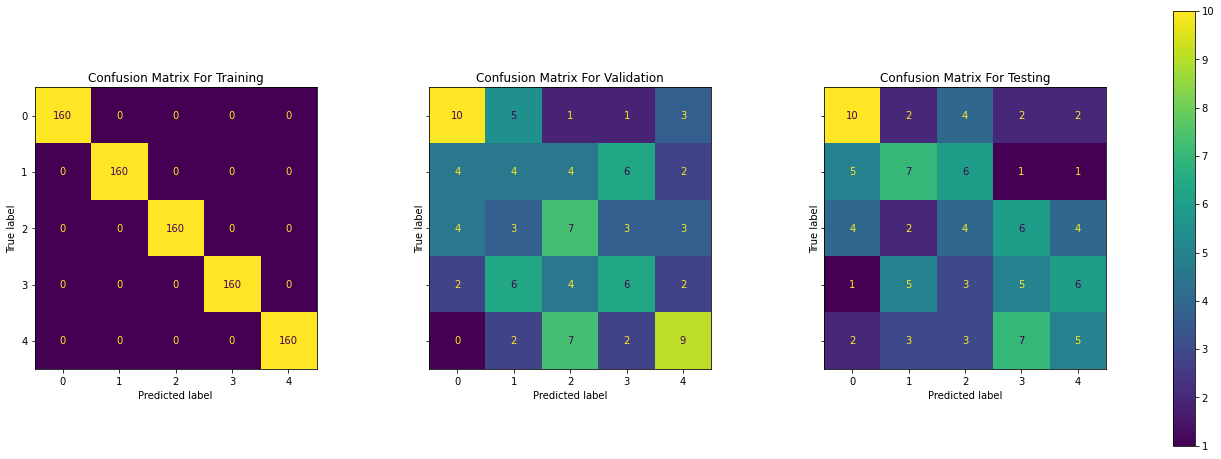

In [ ]:
#1.a
model_vgg_base_class = keras.Sequential()

model_vgg_base_class.add(tf.keras.layers.Rescaling(1.0/255))
#Taking the first two Bloacks from vgg16
for layer in model_to_take_layers_from.layers[:7]:
    model_vgg_base_class.add(layer)

for i in range(1):
    model_vgg_base_class.add(tf.keras.layers.Conv2D(64, 3,activation='relu', padding='same'))
    pass


for i in range(1):
    model_vgg_base_class.add(tf.keras.layers.Conv2D(32, 3,activation='relu'))#Padding Valid output Shape =30*30
    model_vgg_base_class.add(tf.keras.layers.Conv2D(32, 1,activation='relu'))
    model_vgg_base_class.add(tf.keras.layers.Conv2D(8, 1,activation='relu'))

model_vgg_base_class.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model_vgg_base_class.add(tf.keras.layers.Flatten(input_shape=(None, None, None, 8) ))
model_vgg_base_class.add(Dense(5,activation='softmax'))

for layer in model_vgg_base_class.layers[:7]:
    layer.trainable = False

adam =tf.keras.optimizers.Adam(learning_rate = 0.0001)   
sgd = optimizers.SGD(learning_rate = 0.000001, decay = 1e-6, momentum = 0.9)#, nesterov = True)#decay = 1e-6,
model_vgg_base_class_trained=compile_fit_plot(train_generator,train_generator_to_test_with
                                              ,valid_generator,test_generator,model=model_vgg_base_class,opt=adam,
                epochs_num=epochs_num,size_batch=batch_size,model_name="vgg16_Classification",
                loss=tf.keras.losses.CategoricalCrossentropy(),mode='class')


## Transfer Learning - Regression Reformulation

The customized CNN Network of the previous step is reused in the following step with modifing the last layer to treat the problem of classifing the images according to the number of leaves in the plant images as a regresssion task. 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, None, None, None)  0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)  

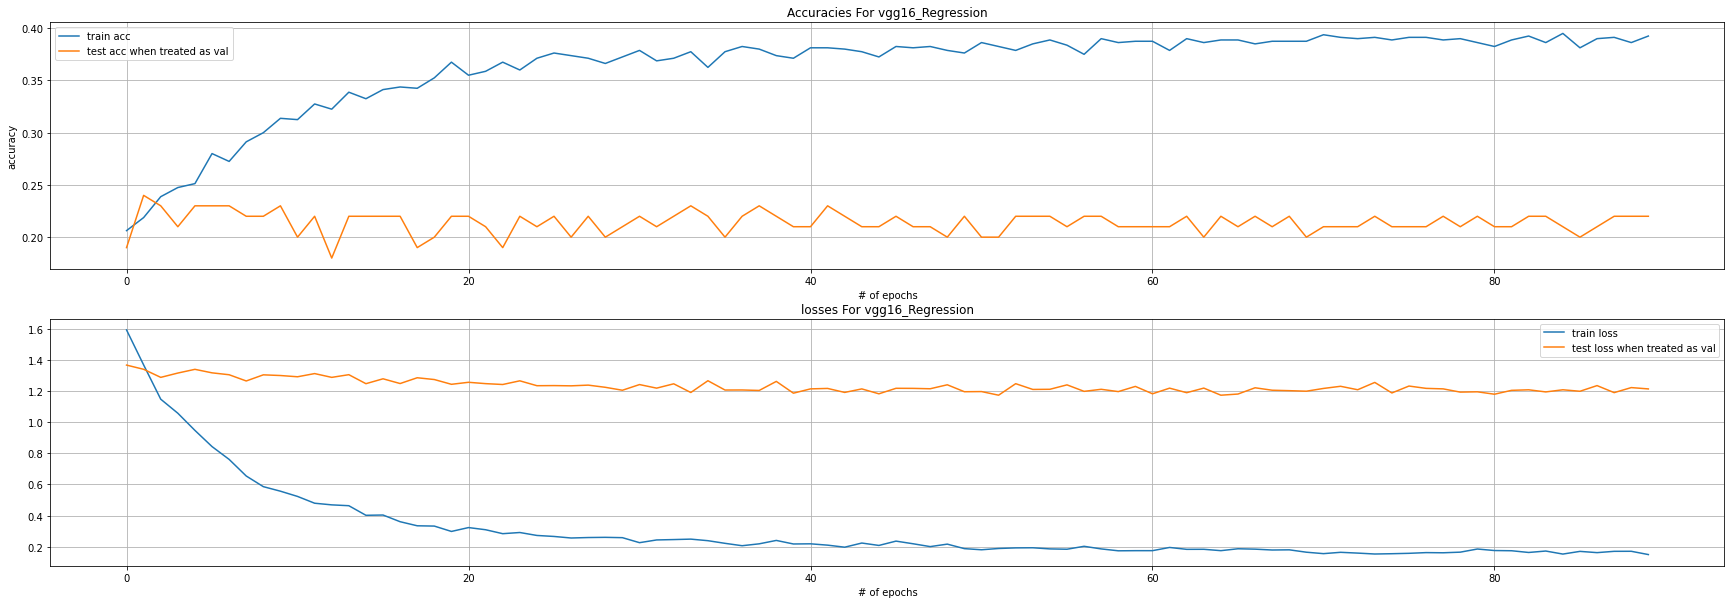

25/25 [==============================] - 3s 134ms/step - loss: 0.1304 - accuracy: 0.3925
Training Evaluation [0.1303703337907791, 0.39250001311302185]
25/25 [==============================] - 3s 133ms/step
Accuracy Score Training after Predict 0.95625
4/4 [==============================] - 0s 103ms/step - loss: 1.2143 - accuracy: 0.2200
Validation Evaluation [1.2142565250396729, 0.2199999988079071]
4/4 [==============================] - 0s 112ms/step
Accuracy Score Validation after Predict 0.31
4/4 [==============================] - 0s 96ms/step - loss: 1.1230 - accuracy: 0.1900
Testing Evaluation [1.1229910850524902, 0.1899999976158142]
4/4 [==============================] - 0s 103ms/step
Accuracy Score Testing after Predict 0.31


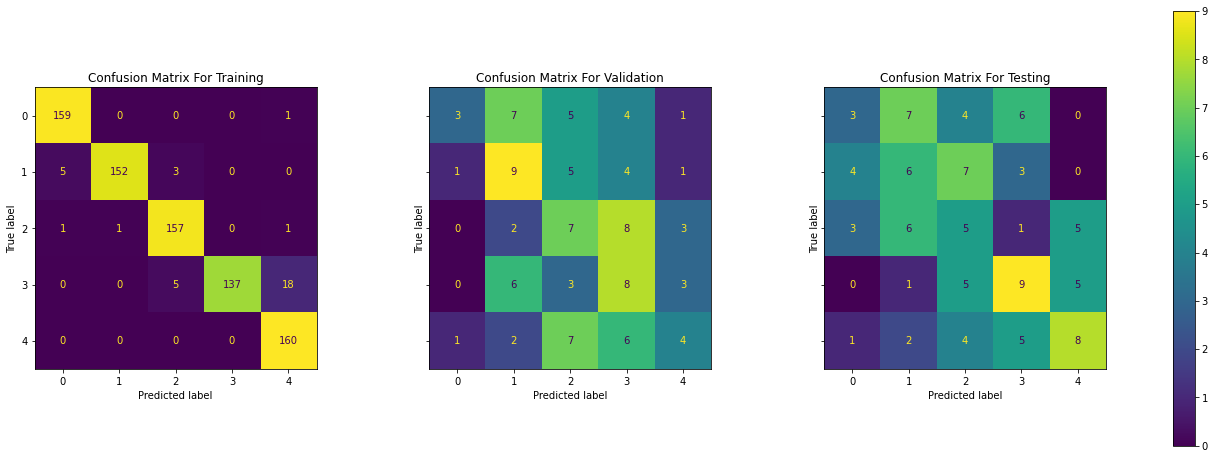

In [ ]:
#1.b
model_vgg_base_reg = keras.Sequential()

inputs=model_to_take_layers_from.input

model_vgg_base_reg.add(tf.keras.layers.Rescaling(1.0/255))
for layer in model_to_take_layers_from.layers[:7]:
    model_vgg_base_reg.add(layer)

for i in range(1):
    model_vgg_base_reg.add(tf.keras.layers.Conv2D(64, 3,activation='relu', padding='same'))
    pass


for i in range(1):
    model_vgg_base_reg.add(tf.keras.layers.Conv2D(32, 3,activation='relu'))
    model_vgg_base_reg.add(tf.keras.layers.Conv2D(32, 1,activation='relu'))
    model_vgg_base_reg.add(tf.keras.layers.Conv2D(8, 1,activation='relu'))

model_vgg_base_reg.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model_vgg_base_reg.add(tf.keras.layers.Flatten(input_shape=(None, None, None, 8) ))
model_vgg_base_reg.add(Dense(1,activation=tf.keras.layers.ReLU( max_value=4)))

#Using Vgg layers with its pretrained weights
for layer in model_vgg_base_reg.layers[:7]:
    layer.trainable = False
mae=tf.keras.losses.MeanAbsoluteError()
adam =tf.keras.optimizers.Adam(learning_rate = 0.0001)   
sgd = optimizers.SGD(learning_rate = 0.000001, decay = 1e-6, momentum = 0.9)#, nesterov = True)#decay = 1e-6,
model_vgg_base_reg_trained=compile_fit_plot(train_generator_rg,train_generator_rg_to_test_with,
                                            valid_generator_rg,test_generator_rg,model=model_vgg_base_reg,opt=adam,
                epochs_num=epochs_num,size_batch=batch_size,model_name="vgg16_Regression",loss=mae,mode='reg')
#model_trained.summary()

## Discussion (Dataset Size and Base Models)


*   Due the small size of the dataset, the two models overfit the train data so fast.
*   Complex cnn models easily overfits the small dataset
*   The two models seem to be not capable of generalizing to deal with validation data.
*   The Loss Curve of the validation for the classification shows only slight convergence in the begining of the training, after which the model starts to overfit the train data and the validation losses increases.as seen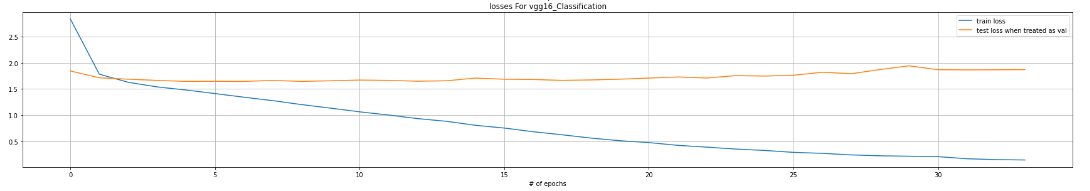

*   The loss curve on validation data of the regression model shows slight decrease at the begining of the training after which it shows no improvement.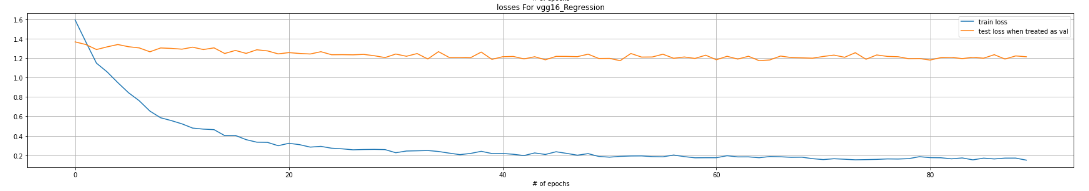
*   The early stopping for this assignment is done based on the val_loss to be suitable for the regression Problem.




## Impact of Regularization and Data Augmantation
* Dropout Layers
* Batch Normalization


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, None, None, None)  0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)  

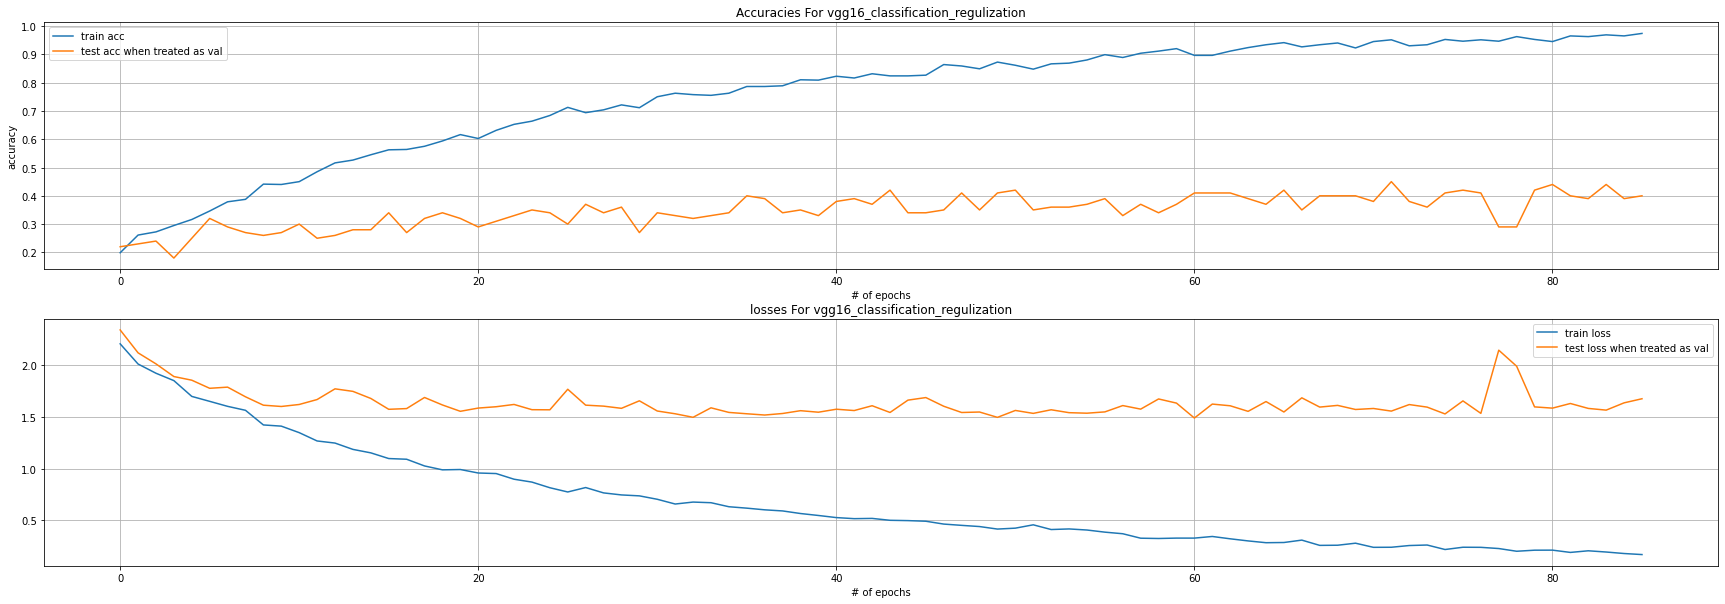

25/25 [==============================] - 3s 131ms/step - loss: 0.1254 - accuracy: 0.9925
Training Evaluation [0.1253787726163864, 0.9925000071525574]
25/25 [==============================] - 3s 131ms/step
Accuracy Score Training after Predict 0.9925
4/4 [==============================] - 0s 103ms/step - loss: 1.6770 - accuracy: 0.4000
Validation Evaluation [1.6769763231277466, 0.4000000059604645]
4/4 [==============================] - 0s 106ms/step
Accuracy Score Validation after Predict 0.4
4/4 [==============================] - 0s 90ms/step - loss: 1.6450 - accuracy: 0.4100
Testing Evaluation [1.645013689994812, 0.4099999964237213]
4/4 [==============================] - 0s 103ms/step
Accuracy Score Testing after Predict 0.41


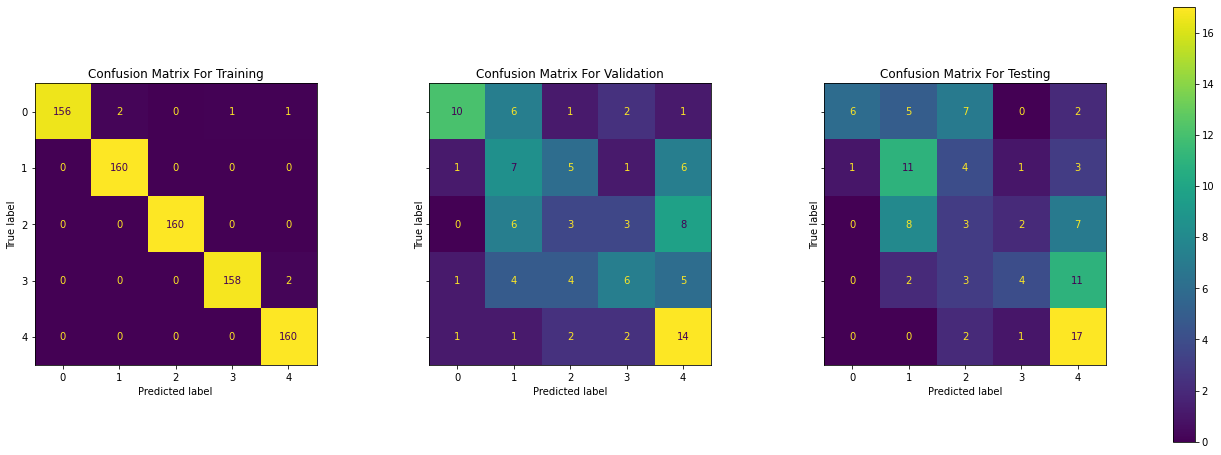

In [ ]:
#3.a
#Adding the rgularization layers
model_vgg_regulariztion_class = keras.Sequential()

model_vgg_regulariztion_class.add(tf.keras.layers.Rescaling(1.0/255))
for layer in model_to_take_layers_from.layers[:7]:
    model_vgg_regulariztion_class.add(layer)

for i in range(1):
    model_vgg_regulariztion_class.add(tf.keras.layers.Conv2D(64, 3,activation='relu', padding='same'))
    model_vgg_regulariztion_class.add(tf.keras.layers.BatchNormalization())
    model_vgg_regulariztion_class.add(tf.keras.layers.Dropout(0.3))
    pass

for i in range(1):
    model_vgg_regulariztion_class.add(tf.keras.layers.Conv2D(32, 3,activation='relu'))
    model_vgg_regulariztion_class.add(tf.keras.layers.Dropout(0.1))
    model_vgg_regulariztion_class.add(tf.keras.layers.BatchNormalization())
    model_vgg_regulariztion_class.add(tf.keras.layers.Conv2D(32, 1,activation='relu'))

    model_vgg_regulariztion_class.add(tf.keras.layers.Dropout(0.1))
    model_vgg_regulariztion_class.add(tf.keras.layers.BatchNormalization())
    model_vgg_regulariztion_class.add(tf.keras.layers.Conv2D(8, 1,activation='relu'))


model_vgg_regulariztion_class.add(tf.keras.layers.BatchNormalization())
model_vgg_regulariztion_class.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model_vgg_regulariztion_class.add(tf.keras.layers.Flatten(input_shape=(None, None, None, 8) ))
model_vgg_regulariztion_class.add(tf.keras.layers.BatchNormalization())
model_vgg_regulariztion_class.add(Dense(5,activation='softmax'))

for layer in model_vgg_regulariztion_class.layers[:7]:
    layer.trainable = False

adam =tf.keras.optimizers.Adam(learning_rate = 0.0001)   
sgd = optimizers.SGD(learning_rate = 0.000001, decay = 1e-6, momentum = 0.9)
model_vgg_regulariztion_class_trained=compile_fit_plot(train_generator,train_generator_to_test_with,
                                                       valid_generator,test_generator,model=model_vgg_regulariztion_class,opt=adam,
                epochs_num=epochs_num,size_batch=batch_size,model_name="vgg16_classification_regulization",loss=tf.keras.losses.CategoricalCrossentropy(),mode='class')


Found 800 images belonging to 5 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, None, None, None)  0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2

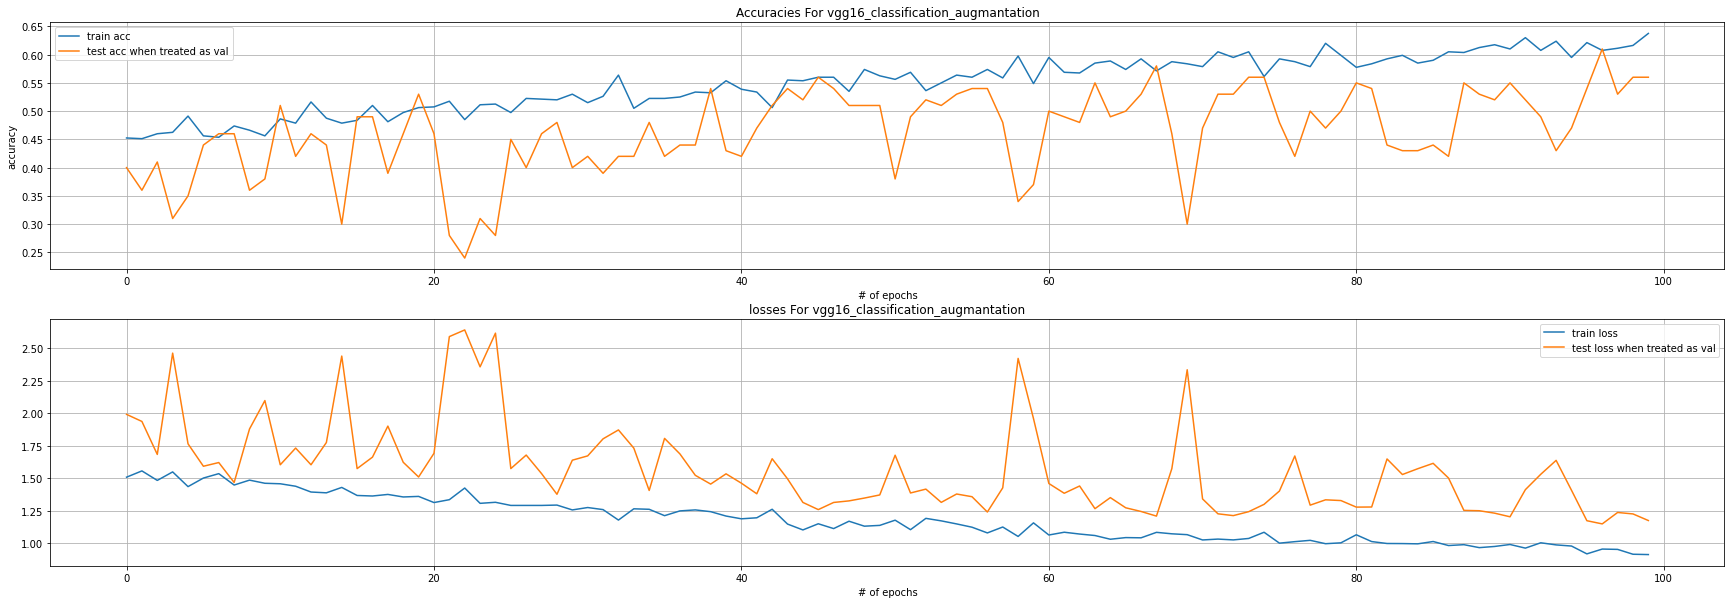

25/25 [==============================] - 3s 133ms/step - loss: 0.5594 - accuracy: 0.7763
Training Evaluation [0.5594418048858643, 0.7762500047683716]
25/25 [==============================] - 3s 135ms/step
Accuracy Score Training after Predict 0.77625
4/4 [==============================] - 0s 101ms/step - loss: 1.1754 - accuracy: 0.5600
Validation Evaluation [1.1754217147827148, 0.5600000023841858]
4/4 [==============================] - 0s 107ms/step
Accuracy Score Validation after Predict 0.56
4/4 [==============================] - 0s 97ms/step - loss: 1.3140 - accuracy: 0.5700
Testing Evaluation [1.3139889240264893, 0.5699999928474426]
4/4 [==============================] - 0s 100ms/step
Accuracy Score Testing after Predict 0.57


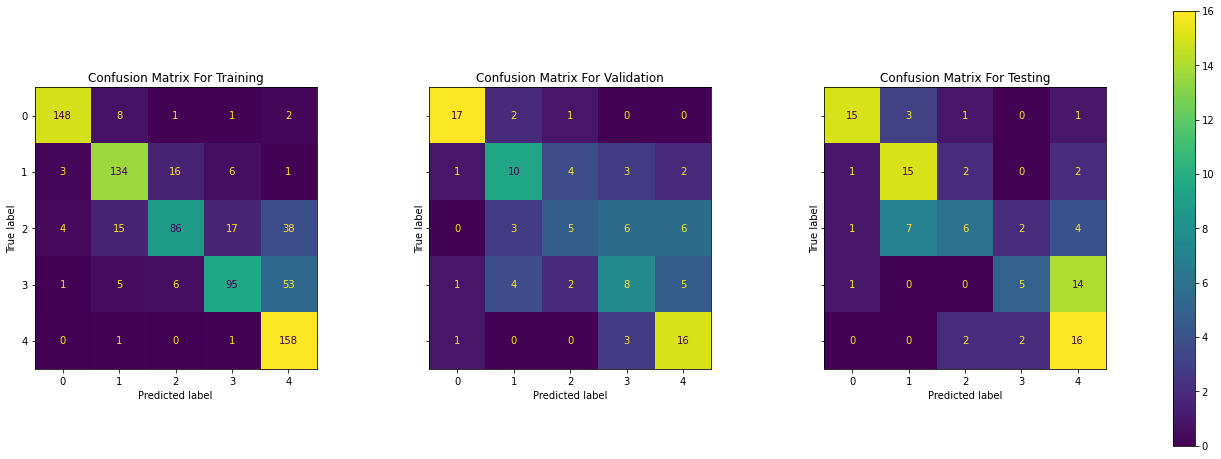

In [ ]:
# Data Augmantation
#step 2
train_datagen_augmant = ImageDataGenerator(preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',validation_split=1/9)
Augmanting the train data
train_generator_aug = train_datagen_augmant.flow_from_directory(
        train_directory,
        target_size=target_size,
        batch_size=batch_size, class_mode="categorical",subset='training'
    )


adam =tf.keras.optimizers.Adam(learning_rate = 0.0001)   
sgd = optimizers.SGD(learning_rate = 0.000001, decay = 1e-6, momentum = 0.9)

model_vgg_regulariztion_class_trained_aug=compile_fit_plot(train_generator_aug,train_generator_to_test_with,
                                                           valid_generator,test_generator,model=model_vgg_regulariztion_class,opt=adam,
                epochs_num=epochs_num,size_batch=batch_size,model_name="vgg16_classification_augmantation",loss=tf.keras.losses.CategoricalCrossentropy(),mode='class')


## Discussion (Regulariztion and Data Augmantation)

*  Adding the Regularization resulted in slower learning curve for the train data, reduced the problem of overfitting and increased the model capability to predict the validation and test data
*  Augmanting the train data for the model with the regulariztion layers significantly improved the model learning and generaliztion, which could be seen from the loss and accuracy curves.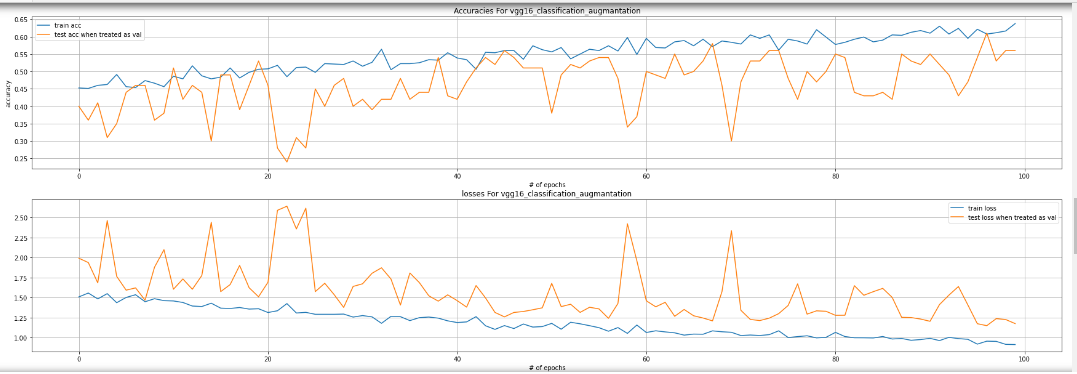
*  The accuracy curves for the train and validation are increasing side by side.
*  The loss curves are deacreasing together.
*  The number of epochs needs to be increased to achieve a full or a better convergense.
*  The Accuracy after regularization and data augmantation is almost the double of the accuracy of the base line model, even without a full convergense.
*  As sseen from the confusion matrix, The model gives the lowest prediction rate for plants with 3 oand 4 leafs. Visualizing the data earlier showed that these two classes are hard to distinguch from other classes and to distinguacone from the other using the human eyes.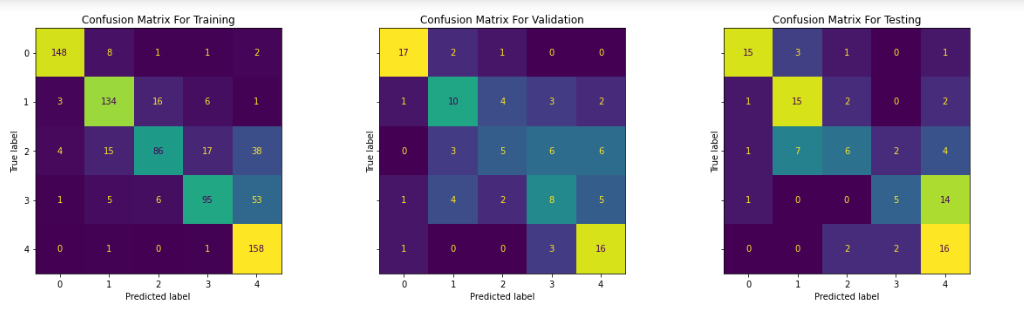






## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.